# Movie Recommendation Predict Solution

© Explore Data Science Academy

---
### Honour Code

We, **Team CW2**, confirm - by submitting this document - that the solutions in this notebook are a result of our own work and that we abide by the [EDSA honour code](https://drive.google.com/file/d/1QDCjGZJ8-FmJE3bZdIQNwnJyQKPhHZBn/view?usp=sharing).

Non-compliance with the honour code constitutes a material breach of contract.

### Overview: Movie Recommendation Predict

In today’s technology driven world, recommender systems are socially and economically critical for ensuring that individuals can make appropriate choices surrounding the content they engage with on a daily basis. One application where this is especially true surrounds movie content recommendations; where intelligent algorithms can help viewers find great titles from tens of thousands of options.

…ever wondered how Netflix, Amazon Prime, Showmax, Disney and the likes somehow know what to recommend to you?

<br></br>

<div align="center" style="width: 600px; font-size: 80%; text-align: center; margin: 0 auto">
<img src="https://th.bing.com/th/id/R.e6c438e764799de9a90ae10bd32c51cc?rik=C6ZSfBftJJQzBg&pid=ImgRaw&r=0.png"
     alt="Some languages for your fine model"
     style="float: center; padding-bottom=0.5em"
     width=600px/>

</div>

…it's not just a guess drawn out of the hat. There is an algorithm behind it.

With this context, EDSA is challenging you to construct a recommendation algorithm based on content or collaborative filtering, capable of accurately predicting how a user will rate a movie they have not yet viewed based on their historical preferences.

> **What value is achieved through building a functional recommender system?**

Providing an accurate and robust solution to this challenge has immense economic potential, with users of the system being exposed to content they would like to view or purchase - generating revenue and platform affinity.

<a id="cont"></a>

## Table of Contents

<a href=#one>1. Importing Packages</a>

<a href=#two>2. Loading Data</a>

<a href=#three>3. Exploratory Data Analysis (EDA) & Data Engineering</a>

<a href=#five>4. Modeling</a>

<a href=#six>5. Model Performance</a>

<a href=#seven>6. Model Explanation</a>

<a href=#four>7. Kaggle Submission</a>

<a href=#four>8. Saving The Model</a>


 <a id="one"></a>
## 1. Importing Packages
<a href=#cont>Back to Table of Contents</a>



In [3]:


# Import libraries for operating system
import os

# Data processing
import numpy as np
import pandas as pd
import datetime
import math
from sklearn import preprocessing
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from scipy.sparse import csr_matrix
import scipy as sp

# Plotting packages
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
%matplotlib inline

# Packages for modeling
import surprise
from surprise import Reader
from surprise import Dataset
from surprise import KNNWithMeans
from surprise import KNNBasic
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise import BaselineOnly
from surprise import NormalPredictor
from sklearn.neighbors import  NearestNeighbors
import heapq

# Packages for model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from time import time

# Import recommendation system library to predict ratings
from reco_utils.recommender.surprise.surprise_utils import predict

# Import recommendation system library to evaluate predicted ratings
from reco_utils.evaluation.python_evaluation import (rmse,mae)

# Packages for saving models
import pickle

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Packages for Randomisation
import random

%matplotlib inline



<a id="two"></a>
## 2. Loading the Data
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>



In [4]:


#load the data
genome_scores = pd.read_csv('genome_scores.csv')

genome_tags = pd.read_csv('genome_tags.csv')

imdb = pd.read_csv('imdb_data.csv')

links = pd.read_csv('links.csv')

movies = pd.read_csv('movies.csv')

sample = pd.read_csv('sample_submission.csv')

tags = pd.read_csv('tags.csv')

train = pd.read_csv('train.csv')

test = pd.read_csv('test.csv')



In [5]:


print("Genome scores =", genome_scores.shape)
print("Genome tags =", genome_tags.shape)
print("imdb =", imdb.shape)
print("Links =", links.shape)
print("Movies =", movies.shape)
print("Sample =", sample.shape)
print("Tags =", tags.shape)
print("Train =", train.shape)
print("Test =", test.shape)



Genome scores = (15584448, 3)
Genome tags = (1128, 2)
imdb = (27278, 6)
Links = (62423, 3)
Movies = (62423, 3)
Sample = (5000019, 2)
Tags = (1093360, 4)
Train = (10000038, 4)
Test = (5000019, 2)


<a id="six"></a>
<a class="anchor" id="4"></a>

Looking at the dataframes, we can see that they are going to need some processing power to handle it all. The data set is more than perfect to use to train our models as the it contains numerical types. Let us start working through our data then.


<a id="three"></a>
## Data Cleaning and Data Preprocessing
<a class="anchor" id="1.1"></a>

Let us look at the data even further to identify any form of flaws such as empty cells to help us understand the data even more.


In [6]:


# show all the information for all datasets
file_names = ['genome_scores', 'genome_tags', 'imdb', 'links', 'movies', 'sample', 'tags', 'test', 'train']
files = [genome_scores, genome_tags, imdb, links, movies, sample, tags, test, train]

for name, file in zip(file_names,files):
    print(name)
    print("")
    print(file.info())
    print("")
    print("Null values:")
    print(file.isnull().sum())
    print("")
    print(file.head(3))
    print("")
    print(file.describe())
    print("\n\n------------------------------------------\n\n")
    
    

genome_scores

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15584448 entries, 0 to 15584447
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   movieId    int64  
 1   tagId      int64  
 2   relevance  float64
dtypes: float64(1), int64(2)
memory usage: 356.7 MB
None

Null values:
movieId      0
tagId        0
relevance    0
dtype: int64

   movieId  tagId  relevance
0        1      1    0.02875
1        1      2    0.02375
2        1      3    0.06250

            movieId         tagId     relevance
count  1.558445e+07  1.558445e+07  1.558445e+07
mean   4.602249e+04  5.645000e+02  1.163679e-01
std    5.535221e+04  3.256254e+02  1.544722e-01
min    1.000000e+00  1.000000e+00  2.500000e-04
25%    3.853750e+03  2.827500e+02  2.400000e-02
50%    8.575500e+03  5.645000e+02  5.650000e-02
75%    8.018650e+04  8.462500e+02  1.407500e-01
max    2.064990e+05  1.128000e+03  1.000000e+00


------------------------------------------


genome_tags

<class 'pand

             userId       movieId        rating     timestamp
count  1.000004e+07  1.000004e+07  1.000004e+07  1.000004e+07
mean   8.119909e+04  2.138911e+04  3.533395e+00  1.215677e+09
std    4.679359e+04  3.919578e+04  1.061124e+00  2.268921e+08
min    1.000000e+00  1.000000e+00  5.000000e-01  7.896520e+08
25%    4.051000e+04  1.197000e+03  3.000000e+00  1.011742e+09
50%    8.091400e+04  2.947000e+03  3.500000e+00  1.199019e+09
75%    1.215790e+05  8.630000e+03  4.000000e+00  1.447242e+09
max    1.625410e+05  2.091710e+05  5.000000e+00  1.574328e+09


------------------------------------------




<a id="six"></a>
<a class="anchor" id="4"></a>
> **Observations**

We can see that imdb, links and tabs are the ones with some empty cells. So let us fill the empty cells with some relevant data types irespectively.

In [7]:


# Fill all the empty cells of imdb with relevant data type
imdb['title_cast'] = imdb['title_cast'].fillna('')
imdb['director'] = imdb['director'].fillna('')
imdb['runtime'] = imdb['runtime'].fillna(0)
imdb['budget'] = imdb['budget'].fillna('')
imdb['plot_keywords'] = imdb['plot_keywords'].fillna('')

# Fill all the empty cells of links with relevant data type
links['tmdbId'] = links['tmdbId'].fillna(0)

# Fill all the empty cells of tags with relevant data type
tags['tag'] = tags['tag'].fillna('')



<a id="six"></a>
<a class="anchor" id="4"></a>

Looking at the movies dataframe, we can see that titles and years fall under one column so let us split them and put each in their respective columns of their own. We should also split genres while we are still at that.


In [8]:


# Split all the genres
movies['genres'] = movies['genres'].apply(lambda m : ' '.join(m.split('|')))

# Extract the year of all movies from title
movies['year'] = movies['title'].apply(lambda m : re.findall(r'\((.[\d]+)\)',m))
movies['year'] = movies['year'].str[-1]
movies['year'] = movies['year'].fillna(0)
movies['year'] = movies['year'].astype('int')

# Split all the titles
movies['new_title'] = movies['title'].apply(lambda m : m.split('('))
movies['new_title'] = movies['new_title'].apply(lambda m : m[0])



In [9]:


# Have a look at the new Movies dataframe
movies.head(3)



,movieId,title,genres,year,new_title
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1995,Toy Story
1,2,Jumanji (1995),Adventure Children Fantasy,1995,Jumanji
2,3,Grumpier Old Men (1995),Comedy Romance,1995,Grumpier Old Men


In [10]:


# Split all title_cast in imdb_data
imdb['title_cast'] = imdb['title_cast'].apply(lambda i : ' '.join(i.split('|')))

# Split all plot_keywords in imdb_data
imdb['plot_keywords'] = imdb['plot_keywords'].apply(lambda i : ' '.join(i.split('|')))

imdb.head(3)



,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks Tim Allen Don Rickles Jim Varney Wal...,John Lasseter,81.0,"$30,000,000",toy rivalry cowboy cgi animation
1,2,Robin Williams Jonathan Hyde Kirsten Dunst Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game adventurer fight game
2,3,Walter Matthau Jack Lemmon Sophia Loren Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat lake neighbor rivalry


<a id="three"></a>
## 3. Exploratory Data Analysis (EDA) & Data Engineering
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>




In [11]:
ratings = train.copy()
ratings.groupby('movieId').count()

,userId,rating,timestamp
movieId,,,
1,23062,23062,23062
2,9654,9654,9654
3,4727,4727,4727
4,968,968,968
5,4648,4648,4648
...,...,...,...
209145,1,1,1
209153,1,1,1
209159,1,1,1


In [12]:
# Maintain ratings that >= 255 movies
ratings_f = ratings.groupby('userId').filter(lambda x: len(x) >= 400)

# Check out movie titles that makes the list of 55 or more ratings
movie_list_rating = ratings_f.movieId.unique().tolist()

In [13]:
# Chech out new lenth and compare with all movies
len(ratings_f), len(ratings)

(1677256, 10000038)

In [14]:
# filter the movie data frame
movies = movies[movies.movieId.isin(movie_list_rating)]

In [15]:
movies.head(2)

,movieId,title,genres,year,new_title
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1995,Toy Story
1,2,Jumanji (1995),Adventure Children Fantasy,1995,Jumanji


In [16]:


new_df = ratings_f.copy()

# Merge movies and imdb dataframes to training dataframe
new_df = new_df.merge(movies, how = 'left', on = 'movieId')
new_df = new_df.merge(imdb, how = 'left', on = 'movieId')



In [17]:


print("Merged Dataframe =", new_df.shape)



Merged Dataframe = (1677256, 13)


In [18]:


new_df.head(10)



,userId,movieId,rating,timestamp,title,genres,year,new_title,title_cast,director,runtime,budget,plot_keywords
0,106362,32296,2.0,1423042565,Miss Congeniality 2: Armed and Fabulous (2005),Adventure Comedy Crime,2005,Miss Congeniality 2: Armed and Fabulous,Sandra Bullock Regina King Enrique Murciano Wi...,Marc Lawrence,115.0,"$45,000,000",female protagonist cleave gag good woman fbi
1,40858,5025,3.5,1090061607,Orange County (2002),Comedy,2002,Orange County,Colin Hanks Jack Black Schuyler Fisk Bret Harr...,Mike White,82.0,"$18,000,000",high school senior slacker stanford university...
2,6063,33493,3.0,1236048966,Star Wars: Episode III - Revenge of the Sith (...,Action Adventure Sci-Fi,2005,Star Wars: Episode III - Revenge of the Sith,Ewan McGregor Natalie Portman Hayden Christens...,George Lucas,140.0,"$113,000,000",elongated cry of no personality change tragic ...
3,95075,41571,3.0,1141842530,Memoirs of a Geisha (2005),Drama Romance,2005,Memoirs of a Geisha,Suzuka Ohgo Togo Igawa Mako Samantha Futerman ...,Robin Swicord,145.0,"$85,000,000",chinese actress playing japanese character sum...
4,146347,1129,4.0,974748535,Escape from New York (1981),Action Adventure Sci-Fi Thriller,1981,Escape from New York,,,0.0,,
5,89538,6538,3.5,1288027099,Swimming Pool (2003),Drama Mystery Thriller,2003,Swimming Pool,Charlotte Rampling Ludivine Sagnier Charles Da...,François Ozon,102.0,,bilingual nude swimming cheating girlfriend ba...
6,50882,89745,5.0,1549949960,"Avengers, The (2012)",Action Adventure Sci-Fi IMAX,2012,"Avengers, The",Robert Downey Jr. Chris Evans Mark Ruffalo Chr...,Joss Whedon,143.0,"$220,000,000",superhero marvel cinematic universe alien inva...
7,110466,8984,3.5,1487725400,Ocean's Twelve (2004),Action Comedy Crime Thriller,2004,Ocean's Twelve,Brad Pitt Catherine Zeta-Jones George Clooney ...,Steven Soderbergh,125.0,"$110,000,000",heist sequel pretending to be pregnant father ...
8,80247,4069,3.0,1313034518,"Wedding Planner, The (2001)",Comedy Romance,2001,"Wedding Planner, The",Jennifer Lopez Matthew McConaughey Bridgette W...,Pamela Falk,103.0,"$35,000,000",therapist love triangle man wears eyeglasses w...
9,97452,6998,3.5,1308144440,House of Cards (1993),Drama,1993,House of Cards,Kathleen Turner Tommy Lee Jones Asha Menina Sh...,Michael Lessac,0.0,,child's point of view reflection cathartic the...


In [19]:


new_df.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 1677256 entries, 0 to 1677255
Data columns (total 13 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   userId         1677256 non-null  int64  
 1   movieId        1677256 non-null  int64  
 2   rating         1677256 non-null  float64
 3   timestamp      1677256 non-null  int64  
 4   title          1677256 non-null  object 
 5   genres         1677256 non-null  object 
 6   year           1677256 non-null  int32  
 7   new_title      1677256 non-null  object 
 8   title_cast     1565480 non-null  object 
 9   director       1565480 non-null  object 
 10  runtime        1565480 non-null  float64
 11  budget         1565480 non-null  object 
 12  plot_keywords  1565480 non-null  object 
dtypes: float64(2), int32(1), int64(3), object(7)
memory usage: 172.8+ MB


In [20]:


new_df.describe()



,userId,movieId,rating,timestamp,year,runtime
count,1.677256e+06,1.677256e+06,1.677256e+06,1.677256e+06,1.677256e+06,1.565480e+06
mean,8.139014e+04,3.152291e+04,3.231642e+00,1.280757e+09,1.992790e+03,7.644653e+01
std,4.645433e+04,4.735111e+04,1.043613e+00,1.991072e+08,5.856357e+01,5.516561e+01
min,1.870000e+02,1.000000e+00,5.000000e-01,8.502443e+08,0.000000e+00,0.000000e+00
25%,3.973200e+04,2.109000e+03,2.500000e+00,1.107856e+09,1.988000e+03,0.000000e+00
50%,8.078000e+04,4.966000e+03,3.500000e+00,1.282012e+09,1.998000e+03,9.800000e+01
75%,1.217250e+05,5.272200e+04,4.000000e+00,1.469773e+09,2.006000e+03,1.150000e+02
max,1.625160e+05,2.091350e+05,5.000000e+00,1.574315e+09,2.019000e+03,8.770000e+02


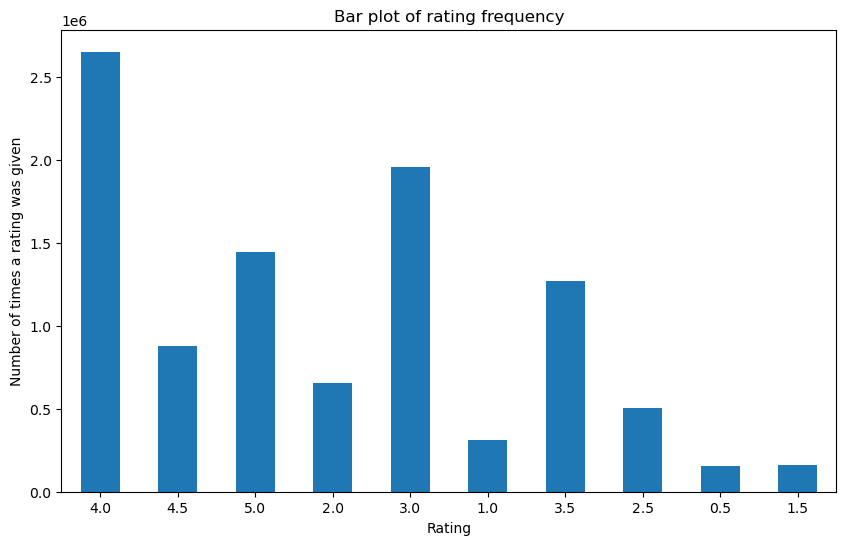

In [21]:


#rating distribution
train['rating'].value_counts(sort=False).plot(kind='bar' ,figsize=(10,6), use_index = True, rot=0)
plt.title('Bar plot of rating frequency')
plt.xlabel('Rating')
plt.ylabel('Number of times a rating was given')
label = list(train['rating'].value_counts(sort=False))



<AxesSubplot: xlabel='count', ylabel='year'>

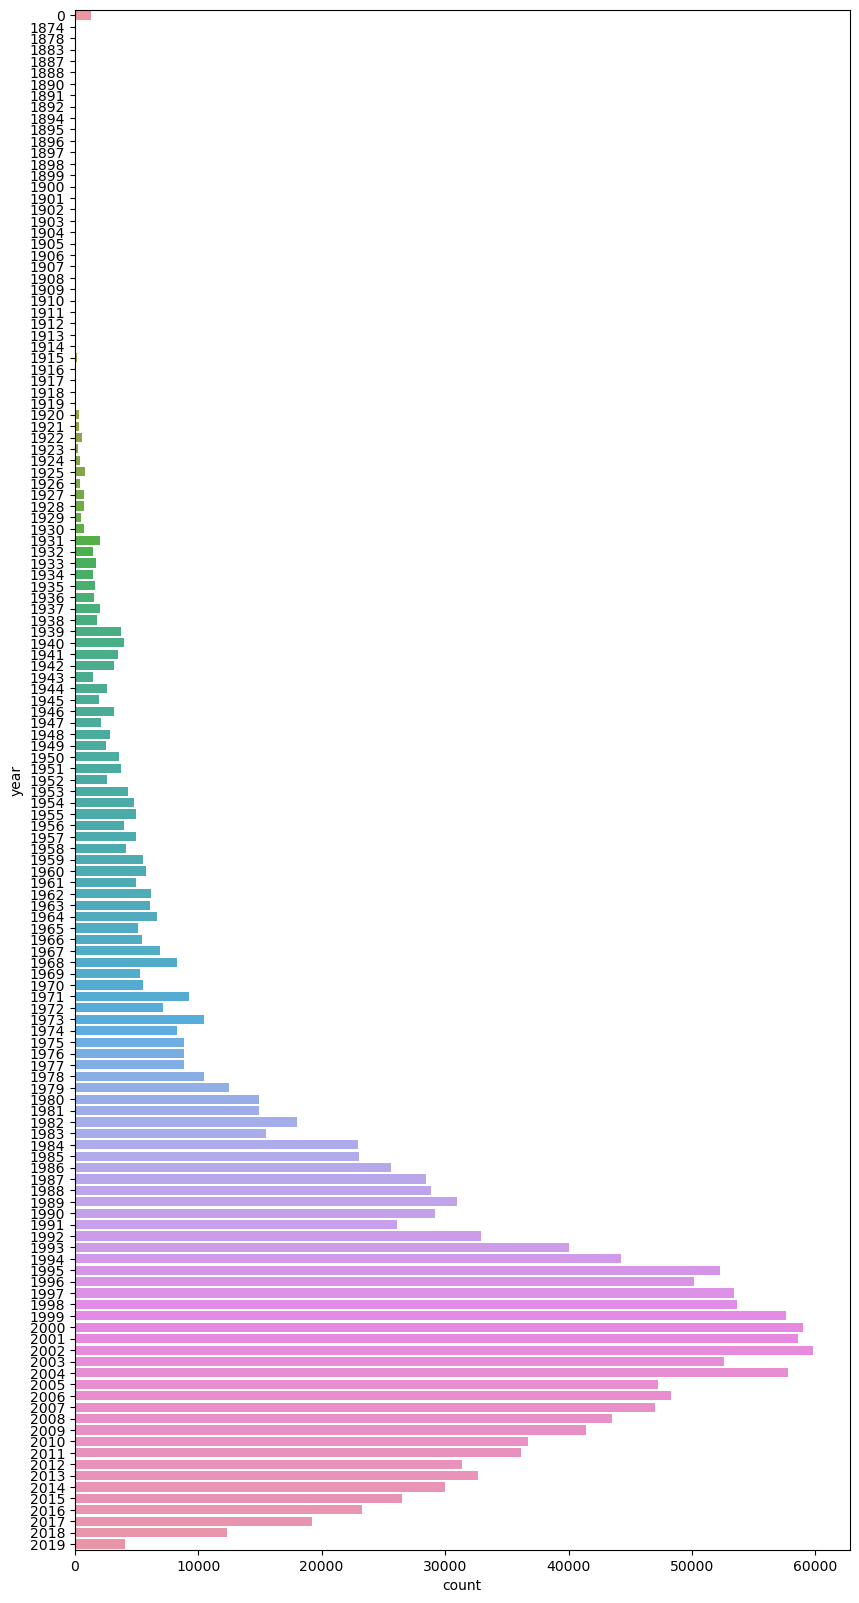

In [22]:


#have a look at feature distributions

#year distribution
fig , ax = plt.subplots(figsize=(10,20))
sns.countplot(y = new_df['year'])



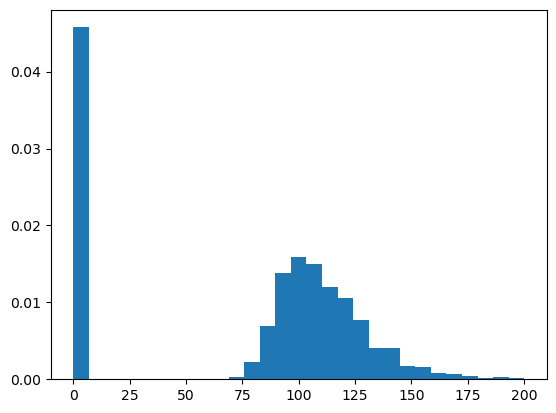

In [23]:


plt.hist(new_df['runtime'], density=True, orientation='vertical', bins=np.linspace(0,200,30))
plt.show()



In [24]:


# Top rated movies
top_movies = new_df['new_title'].value_counts()
top_movies[:10]



Planet of the Apes       1439
King Kong                1291
Ghostbusters             1164
Total Recall             1153
Ocean's Eleven           1131
Gladiator                1115
Godzilla                 1088
Mummy, The               1068
Batman                   1057
Beauty and the Beast     1052
Name: new_title, dtype: int64

In [25]:


# identify number of training data columns and row
print(fr'data rows = {new_df.shape[0]}')
print(fr'data columns = {new_df.shape[1]}')



data rows = 1677256
data columns = 13


In [26]:


print(fr"Number of users in training dataset = {new_df['userId'].nunique()}")
print(fr"Number of movies in training dataset = {new_df['movieId'].nunique()}")



Number of users in training dataset = 2674
Number of movies in training dataset = 43748


<AxesSubplot: xlabel='rating', ylabel='count'>

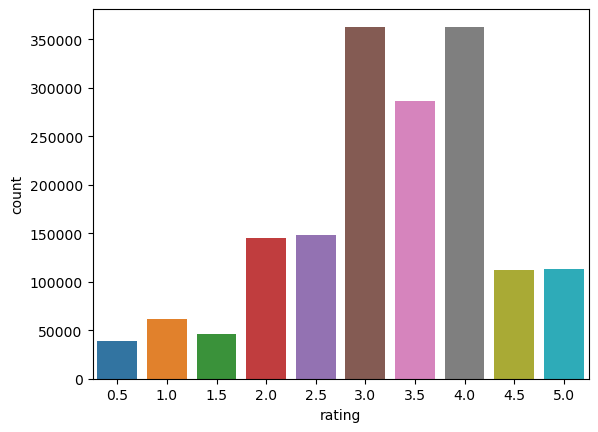

In [27]:


# display rating distribution for training dataset
sns.countplot(x = new_df['rating'])



<AxesSubplot: >

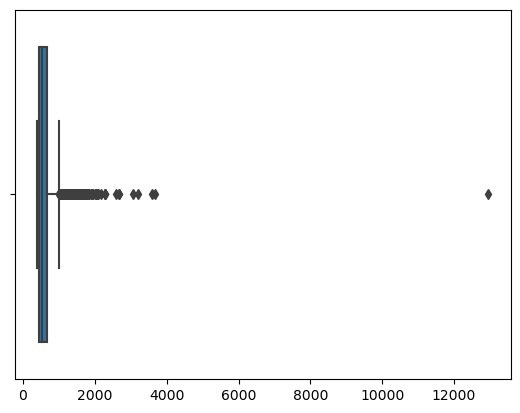

In [28]:


# identify any outliers in dataset
sns.boxplot(x = new_df['userId'].value_counts().values)



In [29]:


# descriptive statistics of users count
new_df['userId'].value_counts().describe()



count     2674.000000
mean       627.246073
std        377.283885
min        400.000000
25%        451.250000
50%        527.000000
75%        672.000000
max      12952.000000
Name: userId, dtype: float64

In [30]:


# display amount of votes per user (highest to lowest)
new_df['userId'].value_counts()



72315     12952
80974      3680
137293     3588
33844      3208
20055      3050
          ...  
12960       401
149340      400
63967       400
58046       400
150468      400
Name: userId, Length: 2674, dtype: int64

In [31]:


# assign outlier user vote amount to variable
outlier = new_df['userId'].value_counts()
print(f'Outlier information \n\nuserId:{outlier.index[0]} Votes:{outlier.iloc[0]}')



Outlier information 

userId:72315 Votes:12952


In [32]:


# assign total count of votes per user to variable
votes_per_user = new_df['userId'].value_counts()

# remove index from series
votes_per_user = votes_per_user.reset_index()

# rename votes_per_user columns
votes_per_user.columns = ['userId','Votes']

# filter and list all users lower than outlier user
votes_per_user = votes_per_user[votes_per_user['Votes']<12952]
votes_per_user = list(votes_per_user['userId'])



In [33]:


# create new training dataset excluding the outlier user
train = new_df[new_df['userId'].isin(votes_per_user)]
print(train.shape)
print(train.head(3))



(1664304, 13)
   userId  movieId  rating   timestamp  \
0  106362    32296     2.0  1423042565   
1   40858     5025     3.5  1090061607   
2    6063    33493     3.0  1236048966   

                                               title                   genres  \
0     Miss Congeniality 2: Armed and Fabulous (2005)   Adventure Comedy Crime   
1                               Orange County (2002)                   Comedy   
2  Star Wars: Episode III - Revenge of the Sith (...  Action Adventure Sci-Fi   

   year                                      new_title  \
0  2005       Miss Congeniality 2: Armed and Fabulous    
1  2002                                 Orange County    
2  2005  Star Wars: Episode III - Revenge of the Sith    

                                          title_cast       director  runtime  \
0  Sandra Bullock Regina King Enrique Murciano Wi...  Marc Lawrence    115.0   
1  Colin Hanks Jack Black Schuyler Fisk Bret Harr...     Mike White     82.0   
2  Ewan McGregor Na

<a id="five"></a>
## 4. Modelling
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>



In [34]:


# create a copy of the train dataset and remove timestamp column
new_data = train.drop(['timestamp','title','genres','year','new_title','title_cast','director','runtime','budget','plot_keywords'],axis = 1)
new_data



,userId,movieId,rating
0,106362,32296,2.0
1,40858,5025,3.5
2,6063,33493,3.0
3,95075,41571,3.0
4,146347,1129,4.0
...,...,...,...
1677251,92041,2942,5.0
1677252,69395,296,5.0
1677253,28884,1230,5.0
1677254,111647,381,5.0


In [35]:


#check for empty cells in training data
new_data.isnull().sum()



userId     0
movieId    0
rating     0
dtype: int64

In [36]:


# parse training data and identify minimum and maximum rating
identifier = Reader(rating_scale = (min(new_data['rating']), max(new_data['rating'])))

# load data from DataFrame
train_model = Dataset.load_from_df(new_data.sample(frac = 0.10, random_state = 42), identifier)

outputs = []

models = ['SVD',
          'SVDpp','NMF',
          'BaselineOnly','NormalPredictor']

instances = [SVD(),
             SVDpp(),NMF(),
             BaselineOnly(),NormalPredictor()]

# iteration of model name and instances to calculate RMSE for model through cross validation
for name, model in zip(models, instances):
    output = cross_validate(model, train_model, measures = ['RMSE'], cv = 3, verbose = False)
    output_prep = pd.DataFrame(output).mean(axis = 0)
    output_prep['model'] = name
    outputs.append(output_prep)
    print(fr"Model: {name}")
    
# display results from sorting by best test_rmse  
print(pd.DataFrame(outputs).set_index('model').sort_values('test_rmse'))



Model: SVD
Model: SVDpp
Model: NMF
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Model: BaselineOnly
Model: NormalPredictor
                 test_rmse   fit_time  test_time
model                                           
SVDpp             0.866863  20.628608   8.402493
BaselineOnly      0.871164   0.826709   0.697553
SVD               0.872394   3.683968   1.053350
NMF               0.958670   7.443536   0.966373
NormalPredictor   1.444278   0.340392   0.645447


<a id="six"></a>
<a class="anchor" id="4"></a>

Let us carry on with BaselineOnly and SVDpp as they both have the lowest rmse.


<a id="six"></a>
<a class="anchor" id="4"></a>
 **Hyperparameter Tuning for SVDpp and BaselineOnly models**



In [37]:


# Hyperparameter Tuning for SVDpp

grid_data = new_data.sample(n = 100000)

# parse training data and identify minimum and maximum rating
identifier = Reader(rating_scale = (min(grid_data['rating']), max(grid_data['rating'])))

# load data from DataFrame
data = Dataset.load_from_df(grid_data[['userId','movieId','rating']], identifier)

# create parameter grid for gridsearch
parameter_grid = {'n_factors': [1],'n_epochs': [20],'init_std_dev':[0.01],'lr_all':[0.0075],'reg_all':[0.007]}

# perform grid search
gridsearch = GridSearchCV(algo_class = SVDpp, param_grid = parameter_grid, cv = 5, return_train_measures = True)
gridsearch.fit(data)

# save gridsearch results
outputs = pd.DataFrame(gridsearch.cv_results)
outputs = outputs[['mean_test_rmse','std_test_rmse','mean_train_rmse','std_train_rmse','rank_test_rmse','mean_fit_time','std_fit_time','mean_test_time','std_test_time','params']]
outputs.sort_values('mean_test_rmse')



,mean_test_rmse,std_test_rmse,mean_train_rmse,std_train_rmse,rank_test_rmse,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params
0,0.87407,0.006644,0.783867,0.001692,1,3.274583,0.090306,1.87454,0.036408,"{'n_factors': 1, 'n_epochs': 20, 'init_std_dev..."


In [38]:


# Hyperparameter Tuning for BaselineOnly model with method sgd

# create copy of model data for grid search
grid_data = new_data.sample(n = 100000)

# parse training data and identify minimum and maximum rating
identifier = Reader(rating_scale = (min(grid_data['rating']), max(grid_data['rating'])))

# load data from DataFrame
data = Dataset.load_from_df(grid_data[['userId','movieId','rating']], identifier)

# create parameter grid for gridsearch
#,'learning_rate':[0.001,0.005,0.010,0.05],'n_epochs':[1,10,20,25]
parameter_grid = {'bsl_options':{'method':['sgd'],'reg':[0.001],'learning_rate':[0.007],'n_epochs':[22]}}

# perform grid search
gridsearch = GridSearchCV(algo_class = BaselineOnly, param_grid = parameter_grid, cv = 5, return_train_measures = True)
gridsearch.fit(data)

# save gridsearch results
outputs = pd.DataFrame(gridsearch.cv_results)
outputs = outputs[['mean_test_rmse','std_test_rmse','mean_train_rmse','std_train_rmse','rank_test_rmse','mean_fit_time','std_fit_time','mean_test_time','std_test_time','params']]
outputs.sort_values('mean_test_rmse')



Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...


,mean_test_rmse,std_test_rmse,mean_train_rmse,std_train_rmse,rank_test_rmse,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params
0,0.86876,0.005445,0.778745,0.001236,1,0.989994,0.05571,0.201634,0.027335,"{'bsl_options': {'method': 'sgd', 'reg': 0.001..."


In [39]:


# Hyperparameter Tuning for BaselineOnly model with method als

# create copy of model data for grid search
grid_data = new_data.sample(n = 100000)

# parse training data and identify minimum and maximum rating
identifier = Reader(rating_scale = (min(grid_data['rating']), max(grid_data['rating'])))

# load data from DataFrame
data = Dataset.load_from_df(grid_data[['userId','movieId','rating']], identifier)

# create parameter grid for gridsearch
#'reg_i':[1,5,10,15],'reg_u':[5,10,15,20],'n_epochs':[1,5,10,15]
parameter_grid = {'bsl_options':{'method':['als'],'reg_i':[5],'reg_u':[4],'n_epochs':[19]}}

# perform grid search
gridsearch = GridSearchCV(algo_class = BaselineOnly, param_grid = parameter_grid, cv = 5, return_train_measures = True)
gridsearch.fit(data)

# save gridsearch results
outputs = pd.DataFrame(gridsearch.cv_results)
outputs = outputs[['mean_test_rmse','std_test_rmse','mean_train_rmse','std_train_rmse','rank_test_rmse','mean_fit_time','std_fit_time','mean_test_time','std_test_time','params']]
outputs.sort_values('mean_test_rmse')



Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


,mean_test_rmse,std_test_rmse,mean_train_rmse,std_train_rmse,rank_test_rmse,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params
0,0.872419,0.005291,0.787566,0.001399,1,0.852963,0.053545,0.21523,0.041215,"{'bsl_options': {'method': 'als', 'reg_i': 5, ..."


<a id="six"></a>
## 5. Model Performance (Model Validation)
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>



<a id="six"></a>
<a class="anchor" id="4"></a>

We are going to use Cross Validation to determine best performing models: Normal against Hyperparameter tuned.

In [40]:


# parse training data and identify minimum and maximum rating
identifier = Reader(rating_scale = (min(new_data['rating']), max(new_data['rating'])))

# load data from DataFrame
train_model = Dataset.load_from_df(new_data.sample(frac = 0.25, random_state = 42), identifier)

outputs = []

models = ['SVDpp',
          'BaselineOnly','SVDpp_hyper',
          'BaselineOnly_als','BaselineOnly_sgd']

instances = [SVDpp(),
             BaselineOnly(),
             SVDpp(n_factors = 1, n_epochs = 20, init_std_dev = 0.01, lr_all = 0.0075, reg_all = 0.007),
             BaselineOnly(bsl_options = {'method':'als','reg_i':5,'reg_u':4,'n_epochs':19}),
             BaselineOnly(bsl_options = {'method':'sgd','reg':0.001,'learning_rate':0.007,'n_epochs':22})]

# iteration of model name and instances to calculate RMSE for model through cross validation
for name, model in zip(models, instances):
    output = cross_validate(model, train_model, measures = ['RMSE'], cv = 5, verbose = False)
    output_prep = pd.DataFrame(output).mean(axis = 0)
    output_prep['model'] = name
    outputs.append(output_prep)
    print(fr"Model: {name}")
    
# display results from sorting by best test_rmse      
print(pd.DataFrame(outputs).set_index('model').sort_values('test_rmse'))



Model: SVDpp
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Model: BaselineOnly
Model: SVDpp_hyper
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Model: BaselineOnly_als
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Model: BaselineOnly_sgd
                  test_rmse    fit_time  test_time
model                                             
SVDpp_hyper        0.826360   52.028543  30.968404
SVDpp              0.831596  181.715844  32.185212
BaselineOnly_als   0.834526    4.462565   1.388164
BaselineOnly_sgd   0.834674    4.827030   1.298138
BaselineOnly       0.840253    2.572079   1.129182


<a id="six"></a>
<a class="anchor" id="4"></a>
> **Model Selection**



In [41]:


# Train final model
new_train = new_data.copy()
print(new_train.head())
new_train.shape



   userId  movieId  rating
0  106362    32296     2.0
1   40858     5025     3.5
2    6063    33493     3.0
3   95075    41571     3.0
4  146347     1129     4.0


(1664304, 3)

In [45]:


# parse training data and identify minimum and maximum rating
identifier = Reader(rating_scale = (min(new_train['rating']), max(new_train['rating'])))

# load data from DataFrame
final_model = Dataset.load_from_df(new_train, reader = identifier)

# build full trainset from the final_model
SVDpp_hyper_final_model = final_model.build_full_trainset()

# create instance of SVDpp hyperparameter model
SVDpp_hyper = SVDpp()

# fit full trainset: SVDpp_hyper_final_model to model
SVDpp_hyper.fit(SVDpp_hyper_final_model)



In [46]:


# display testing data
print(test.head(3))
test.shape



   userId  movieId
0       1     2011
1       1     4144
2       1     5767


(5000019, 2)

In [47]:


# predict test data ratings
test_pred = predict(SVDpp_hyper, test, usercol = 'userId', itemcol = 'movieId')
test_pred



,userId,movieId,prediction
0,1,2011,3.410831
1,1,4144,3.658632
2,1,5767,2.946254
3,1,6711,3.575374
4,1,7318,3.159045
...,...,...,...
5000014,162541,4079,3.306793
5000015,162541,4467,3.499871
5000016,162541,4980,3.038760
5000017,162541,5689,3.002352


In [48]:


# create copy of test predictions dataframe
final_test_pred = test_pred.copy()

# convert columns to string format for concatenation
final_test_pred['userId'] = final_test_pred['userId'].astype('str')
final_test_pred['movieId'] = final_test_pred['movieId'].astype('str')

# add two columns together for submission
final_test_pred['userId_movieId'] = final_test_pred['userId'] + "_" + final_test_pred['movieId']

# rename columns to correct submission columns names
final_test_pred = final_test_pred.rename({'userId_movieId':'Id','prediction':'rating'},axis=1)

# filter for sumbmission columns
final_test_pred = final_test_pred[['Id','rating']]



In [49]:


# Confirm new format
print(final_test_pred.head(3))
print(final_test_pred.shape)



       Id    rating
0  1_2011  3.410831
1  1_4144  3.658632
2  1_5767  2.946254
(5000019, 2)


<a id="six"></a>
## 6. Model Explanation
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>



<a id="three"></a>
## 7. Kaggle Submission
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>




In [50]:


# prediction results to csv file for submission
pd.DataFrame(final_test_pred).to_csv('SVDpp Rating submission.csv', index = False)



<a id="three"></a>
## 8. Saving The Model
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>




In [51]:


# save pickle model
model_save_path = 'SVDpp.pkl'
with open(model_save_path, 'wb') as file:
    pickle.dump(SVDpp_hyper, file)

# load pickle Model
with open(model_save_path, 'rb') as file:
    unpickled_model = pickle.load(file)
    
    

In [52]:


# test prediction with userId and movieId
unpickled_model.predict(6063,33493)



Prediction(uid=6063, iid=33493, r_ui=None, est=2.9851730134787426, details={'was_impossible': False})